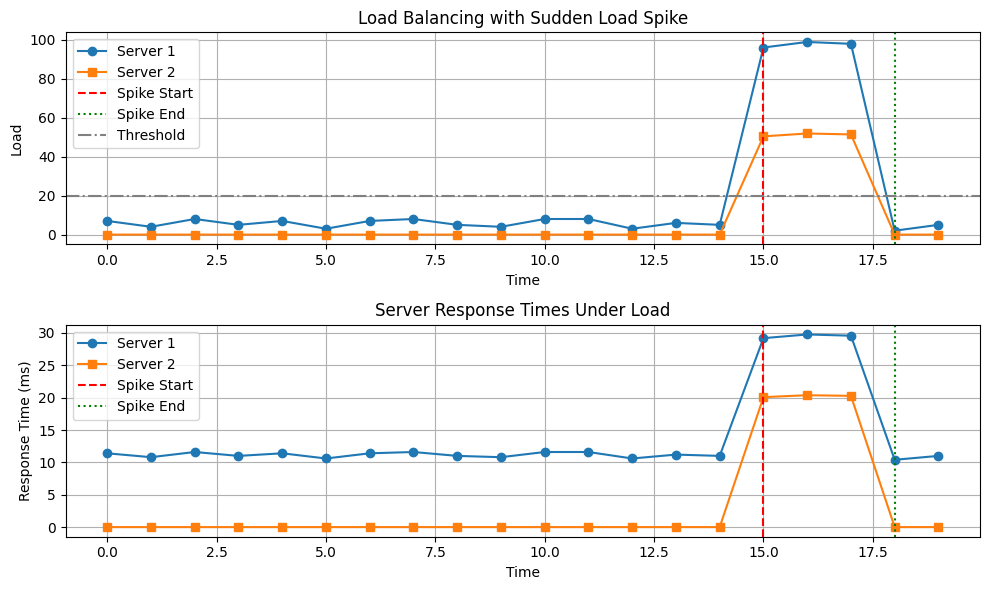

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
time_steps = 20  # Number of time steps (e.g., seconds or minutes)
num_servers = 2   # Number of servers
spike_time = 15   # Time step at which the spike occurs
return_normal_time = 18 # Time step at which the spike ends
spike_magnitude = 200  # Magnitude of the load spike
threshold = 20   # Threshold value to start load balancing

# Simulate normal load (random) and a spike at a specific time
np.random.seed(42)  # For reproducibility
normal_load = np.random.randint(1, 10, size=time_steps)  # Random normal load
load_with_spike = normal_load.copy()

# Introduce a spike at the given time step
load_with_spike[spike_time:] += spike_magnitude  # Add spike after `spike_time`

# End spike at the given time step
load_with_spike[return_normal_time:] -= spike_magnitude

# Simulate load balancing that starts after the threshold is reached
def load_balance(load_data, num_servers, threshold, base_response_time, response_time_multiplier):
    # Create a matrix of loads across servers (rows = time steps, columns = servers)
    server_loads = np.zeros((len(load_data), num_servers))
    server_response_times = np.zeros((len(load_data), num_servers))

    for t in range(len(load_data)):
        load = load_data[t]

        if load > threshold:
            # If load exceeds the threshold, distribute it across servers
            remaining_load = load
            for server in range(num_servers):
                server_loads[t, server] = (remaining_load / num_servers) * 0.95
                remaining_load -= server_loads[t, server]
                
                server_response_times[t, server] = base_response_time + (server_loads[t, server] * response_time_multiplier)
        else:
            # If load is below threshold, assign to only one server (server 0)
            server_loads[t, 0] = load
            server_response_times[t, 0] = base_response_time + (load * response_time_multiplier)


    return server_loads, server_response_times 

# Perform load balancing with a threshold on the data with spike
balanced_loads, balanced_response_times = load_balance(load_with_spike, num_servers, threshold, base_response_time, response_time_multiplier)

# Plotting the results
time = np.arange(time_steps)

plt.figure(figsize=(10, 6))

# Plot load for each server
plt.subplot(2, 1, 1)  # Plot the load on servers

plt.plot(time, balanced_loads[:, 0], label=f"Server 1", marker='o')
plt.plot(time, balanced_loads[:, 1], label=f"Server 2", marker='s')


# Highlight the spike period
plt.axvline(x=spike_time, color='r', linestyle='--', label='Spike Start')
plt.axvline(x=return_normal_time, color='g', linestyle=':', label='Spike End')

# Mark the threshold
plt.axhline(y=threshold, color='grey', linestyle='-.', label='Threshold')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Load")
plt.title("Load Balancing with Sudden Load Spike")
plt.legend(loc='upper left')
plt.grid(True)

# Plot response for each server
plt.subplot(2, 1, 2)  # Plot the response time on servers

plt.plot(time, balanced_response_times[:, 0], label=f"Server 1", marker='o')
plt.plot(time, balanced_response_times[:, 1], label=f"Server 2", marker='s')

# Highlight the spike period
plt.axvline(x=spike_time, color='r', linestyle='--', label='Spike Start')
plt.axvline(x=return_normal_time, color='g', linestyle=':', label='Spike End')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Response Time (ms)")
plt.title("Server Response Times Under Load")
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


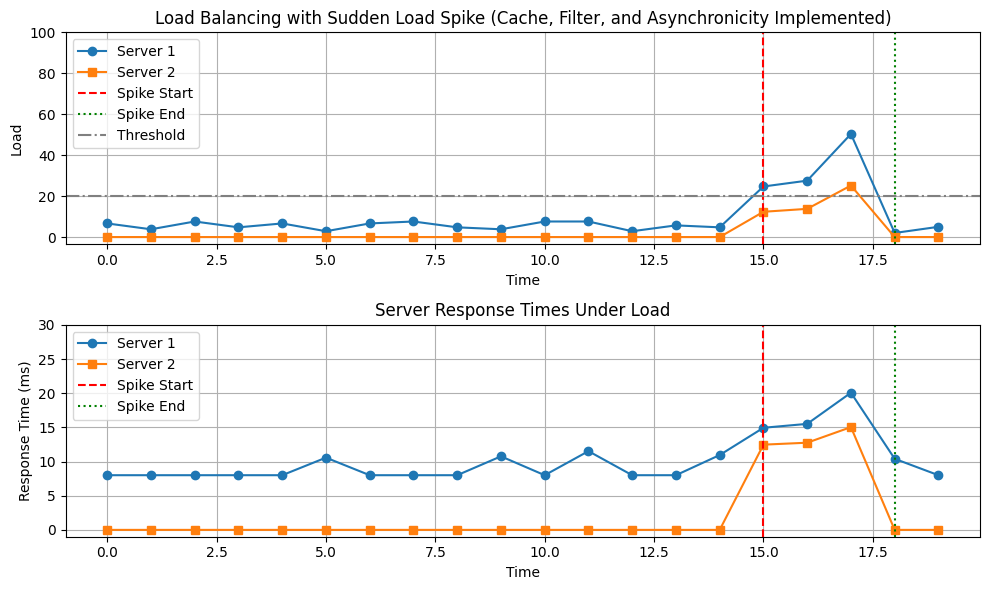

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
time_steps = 20  # Number of time steps (e.g., seconds or minutes)
num_servers = 2   # Number of servers
spike_time = 15   # Time step at which the spike occurs
return_normal_time = 18 # Time step at which the spike ends
spike_magnitude = 200  # Magnitude of the load spike
threshold = 20   # Threshold value to start load balancing
base_response_time = 10  # Base response time for light load (in ms)
response_time_multiplier = 0.2  # Factor by which response time increases with load
cache_size = 5  # Number of cacheable items
cache_hit_probability_base = 0.8  # Base probability of a cache hit
cache_hit_penalty = 2  # Response time reduction factor for cache hits

# Simulate normal load (random) and a spike at a specific time
np.random.seed(42)  # For reproducibility
normal_load = np.random.randint(1, 10, size=time_steps)  # Random normal load
load_with_spike = normal_load.copy()

# Generate staggered spikes for each server over time
spike_times_per_server = []
for server in range(num_servers):
    # Randomly distribute the spikes over the time steps
    staggered_times = np.random.choice(np.arange(spike_time, return_normal_time), 
                                       size=int(spike_magnitude / 67),  # Spread the magnitude over a certain number of steps
                                       replace=False)
    spike_times_per_server.append(staggered_times)

    # Add the spike to the load at these times for this server
    for time in staggered_times:
        load_with_spike[time] += 50  # Increase load by 50 at the staggered times

# Simulate load balancing that starts after the threshold is reached
def load_balance(load_data, num_servers, threshold, base_response_time, response_time_multiplier, cache_size, cache_hit_probability_base, cache_hit_penalty):
    # Create a matrix of loads across servers (rows = time steps, columns = servers)
    server_loads = np.zeros((len(load_data), num_servers))
    server_response_times = np.zeros((len(load_data), num_servers))
    cache = set()  # Cache, represented as a set of item IDs that are cached

    for t in range(len(load_data)):
        # Add filter (Assume 5% of requests are junk)
        load = load_data[t] * 0.95
        cache_hit_probability = cache_hit_probability_base  # Start with a base probability of a cache hit

        # If the spike is over, revert to normal load
        if t >= return_normal_time:
            load = normal_load[t]  # Restore normal load after the spike ends

        if load > threshold:
            # If load exceeds the threshold, distribute it across servers
            remaining_load = load
            for server in range(num_servers):
                server_loads[t, server] = (remaining_load / num_servers)
                remaining_load -= server_loads[t, server]
                actual_cache_hit_prob = max(0, cache_hit_probability - (load / (threshold * 2)))
                
                if np.random.rand() < actual_cache_hit_prob:
                    server_response_times[t, server] = base_response_time - cache_hit_penalty  # Cache hit reduces response time
                else:
                    # Cache miss increases response time based on load
                    server_response_times[t, server] = base_response_time + (server_loads[t, server] * response_time_multiplier)
        else:
            # If load is below threshold, assign to only one server (server 0)
            server_loads[t, 0] = load
             # Check if the request hits the cache
            if np.random.rand() < cache_hit_probability_base:
                server_response_times[t, 0] = base_response_time - cache_hit_penalty  # Cache hit
            else:
                # Cache miss increases response time based on load
                server_response_times[t, 0] = base_response_time + (load * response_time_multiplier)

     # Simulate adding to cache: cache certain items based on load (simple model)
        if len(cache) < cache_size:
            # Add the current load (or request ID) to the cache if space is available
            cache.add(load)
        else:
            # If cache is full, randomly evict an item
            if np.random.rand() < 0.5:  # Eviction chance
                cache.pop()

    return server_loads, server_response_times 

# Perform load balancing with a threshold on the data with spike
balanced_loads, balanced_response_times = load_balance(load_with_spike, num_servers, threshold, base_response_time, response_time_multiplier, cache_size, cache_hit_probability_base, cache_hit_penalty)

# Plotting the results
time = np.arange(time_steps)

plt.figure(figsize=(10, 6))

# Plot load for each server
plt.subplot(2, 1, 1)  # Plot the load on servers

plt.ylim(-3.5,100)
plt.plot(time, balanced_loads[:, 0], label=f"Server 1", marker='o')
plt.plot(time, balanced_loads[:, 1], label=f"Server 2", marker='s')

# Highlight the spike period
plt.axvline(x=spike_time, color='r', linestyle='--', label='Spike Start')
plt.axvline(x=return_normal_time, color='g', linestyle=':', label='Spike End')

# Mark the threshold
plt.axhline(y=threshold, color='grey', linestyle='-.', label='Threshold')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Load")
plt.title("Load Balancing with Sudden Load Spike (Cache, Filter, and Asynchronicity Implemented)")
plt.legend(loc='upper left')
plt.grid(True)

# Plot response for each server
plt.subplot(2, 1, 2)  # Plot the response time on servers
plt.ylim(-1,30) 
plt.plot(time, balanced_response_times[:, 0], label=f"Server 1", marker='o')
plt.plot(time, balanced_response_times[:, 1], label=f"Server 2", marker='s')

# Highlight the spike period
plt.axvline(x=spike_time, color='r', linestyle='--', label='Spike Start')
plt.axvline(x=return_normal_time, color='g', linestyle=':', label='Spike End')

# Labels and title
plt.xlabel("Time")
plt.ylabel("Response Time (ms)")
plt.title("Server Response Times Under Load")
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
